# Scoring Workflow Demo

This notebook demonstrates the core scoring workflow for `sortscore` using the bundled demo dataset.

We will run:

`sortscore -n EXPERIMENT_NAME -e experiment_setup.csv -c config.json`

Then you can inspect:
- Summary stats JSON
- The first few rows of score tables
- Codon and amino-acid heatmap visualizations

## About the demo data

This dataset comes from one sorting experiment using NNN mutagenesis (all codons represented) for deep mutational scanning (DMS) of the GLI2 DNA-binding domain (DBD).

The experiment covers one-fifth of the DBD because this region was targeted by a single oligo.

Count files include unique counts from 3 technical replicates.

## Prerequisites

This notebook assumes `sortscore` is installed and available in the same Python environment as the Jupyter kernel.

Recommended setup (outside this notebook, in terminal from repository root):
```bash
python -m venv .venv
source .venv/bin/activate
pip install -e .
pip install ipykernel
python -m ipykernel install --user --name=sortscore-venv --display-name="Python (sortscore venv)"
```

After setup, select that kernel for this notebook.

In [24]:
import importlib.util
import shutil

cli_path = shutil.which("sortscore")
pkg_ok = importlib.util.find_spec("sortscore") is not None

if cli_path or pkg_ok:
    print("sortscore is installed in this environment.")
    if cli_path:
        print(f"CLI path: {cli_path}")
else:
    print("sortscore is not installed in this environment.")
    print("See installation guide: docs/installation.md")

sortscore is installed in this environment.
CLI path: /Users/c.chitwood/code/sortscore/venv/bin/sortscore


## 1) Set run inputs

Update these variables if your files are in a different location.

In [25]:
from pathlib import Path

EXPERIMENT_NAME = "demo"
EXPERIMENT_SETUP_PATH = "demo_data/GLI2_oPool5b/experiment_setup.csv"
CONFIG_PATH = "demo_data/GLI2_oPool5b/config.json"

def resolve_path(path_str):
    path = Path(path_str)
    candidates = [path, Path("..") / path]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    return path

EXPERIMENT_SETUP_FILE = resolve_path(EXPERIMENT_SETUP_PATH)
CONFIG_FILE = resolve_path(CONFIG_PATH)

print(f"experiment_setup: {EXPERIMENT_SETUP_FILE}")
print(f"config: {CONFIG_FILE}")

experiment_setup: /Users/c.chitwood/code/sortscore/demo_data/GLI2_oPool5b/experiment_setup.csv
config: /Users/c.chitwood/code/sortscore/demo_data/GLI2_oPool5b/config.json


## 2) Run scoring workflow

This executes the full scoring workflow using the paths above.

In [26]:
!sortscore -n {EXPERIMENT_NAME} -e {EXPERIMENT_SETUP_FILE} -c {CONFIG_FILE}

INFO:root:Auto-detected mutagenesis_type: 'dna'
INFO:root:Loaded counts for 3 replicates.
Counts loaded.
INFO:root:Using date-based output suffix: 20260217
INFO:sortscore.utils.analysis_logger:Analysis logger initialized: demo_20260217_20260217_002851
INFO:root:Auto-detected mutagenesis_type: 'dna'
INFO:root:Processing DNA workflow
INFO:root:Calculated DNA scores for 2081 variants.
INFO:root:Saved DNA scores to /Users/c.chitwood/code/sortscore/demo_data/GLI2_oPool5b/output/scores/demo_dna_scores_20260217.csv
INFO:sortscore.utils.analysis_logger:Logged output file: dna_scores -> demo_dna_scores_20260217.csv
INFO:root:Saved stats to /Users/c.chitwood/code/sortscore/demo_data/GLI2_oPool5b/output/scores/demo_dna_stats_20260217.json
INFO:sortscore.utils.analysis_logger:Logged output file: dna_statistics -> demo_dna_stats_20260217.json
INFO:root:Calculated statistics on final DNA scores
INFO:root:Processing AA workflow...
INFO:root:Loading DNA scores from /Users/c.chitwood/code/sortscore/dem

## 3) Resolve output files

In [27]:
import json
import pandas as pd
from IPython.display import Image, Markdown, display

with open(CONFIG_FILE, "r", encoding="utf-8") as f:
    config = json.load(f)

output_dir_cfg = Path(config.get("output_dir", "output"))
if output_dir_cfg.is_absolute():
    output_dir = output_dir_cfg
else:
    output_dir = (CONFIG_FILE.parent / output_dir_cfg).resolve()

scores_dir = output_dir / "scores"
figures_dir = output_dir / "figures"

def newest(base_dir, pattern):
    files = [p for p in base_dir.glob(pattern) if p.is_file() and p.name.startswith(f"{EXPERIMENT_NAME}_")]
    return max(files, key=lambda p: p.stat().st_mtime) if files else None

stats_file = newest(scores_dir, f"{EXPERIMENT_NAME}_aa_stats_*.json") or newest(scores_dir, f"{EXPERIMENT_NAME}_dna_stats_*.json")
aa_scores_file = newest(scores_dir, f"{EXPERIMENT_NAME}_aa_scores_*.csv")
dna_scores_file = newest(scores_dir, f"{EXPERIMENT_NAME}_dna_scores_*.csv")
aa_heatmap_file = newest(figures_dir, f"{EXPERIMENT_NAME}_aa_heatmap_*.png")
codon_heatmap_file = newest(figures_dir, f"{EXPERIMENT_NAME}_codon_heatmap_*.png")

## 4) Print stats JSON

In [28]:
if stats_file is None:
    print("No stats JSON found for this experiment name.")
else:
    with open(stats_file, "r", encoding="utf-8") as f:
        stats = json.load(f)
    print(json.dumps(stats, indent=2))

{
  "all_avg": 1243,
  "all_min": 220,
  "all_max": 2342,
  "syn_avg": 1506,
  "syn_min": 1506,
  "syn_max": 1506,
  "nonsense_avg": 296,
  "nonsense_min": 220,
  "nonsense_max": 433,
  "missense_avg": 1292,
  "missense_min": 306,
  "missense_max": 2342
}


## 5) Show score table heads

In [29]:
if aa_scores_file is None:
    print("No amino-acid scores CSV found for this experiment name.")
else:
    display(Markdown(f"### Amino-acid scores (`{aa_scores_file.name}`)"))
    display(pd.read_csv(aa_scores_file).head())

if dna_scores_file is None:
    print("No DNA/codon scores CSV found for this experiment name.")
else:
    display(Markdown(f"### DNA/codon scores (`{dna_scores_file.name}`)"))
    display(pd.read_csv(dna_scores_file).head())

### Amino-acid scores (`demo_aa_scores_20260217.csv`)

,aa_seq_diff,annotate_aa,avgscore,avgscore_rep_weighted,Rep1.score,Rep2.score,Rep3.score,SD_rep,CV_rep,n_measurements,SEM,CI_lower,CI_upper
0,A.26.*,nonsense,291,291,291,311,270,20,0.070,3,12,240,341
1,A.26.C,missense_aa,942,948,964,1070,792,141,0.149,3,81,593,1291
2,A.26.D,missense_aa,1862,1830,1925,1654,2004,183,0.098,3,106,1406,2316
3,A.26.E,missense_aa,1276,1274,1223,1252,1354,69,0.054,3,40,1106,1446
4,A.26.F,missense_aa,1384,1392,1374,1416,1363,28,0.020,3,16,1315,1454


### DNA/codon scores (`demo_dna_scores_20260217.csv`)

,variant_seq,count.r1b1,count.r1b2,count.r1b3,count.r1b4,count.r2b1,count.r2b2,count.r2b3,count.r2b4,count.r3b1,...,dna_seq_diff,aa_seq,aa_seq_diff,annotate_dna,annotate_aa,SD_rep,CV_rep,n_measurements,CI_lower,CI_upper
0,AAACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,8195.0,24167.0,53644,103224.0,14899.0,30223.0,54252,102591.0,12987.0,...,"T.2.A, C.3.A",KPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.K,missense_dna,missense_aa,103,0.052,3,1735,2245
1,AACCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,4441.0,8140.0,22312,50827.0,4012.0,12954.0,15015,71474.0,1744.0,...,T.2.A,NPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.N,missense_dna,missense_aa,215,0.097,3,1673,2741
2,AAGCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,8438.0,6493.0,16931,26424.0,5834.0,13288.0,18054,36365.0,4440.0,...,"T.2.A, C.3.G",KPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.K,missense_dna,missense_aa,41,0.022,3,1763,1969
3,AATCCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,50567.0,83151.0,98158,98984.0,69898.0,104548.0,81567,127937.0,53167.0,...,"T.2.A, C.3.T",NPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.N,missense_dna,missense_aa,72,0.054,3,1151,1511
4,ACACCTGGCTGCACCAAGAGATACACCGACCCTAGCAGCCTGAGGA...,98.0,145.0,40,213.0,113.0,272.0,129,92.0,3.0,...,"T.2.C, C.3.A",TPGCTKRYTDPSSLRKHVKTVHGPDAHVTKKQR,I.1.T,missense_dna,missense_aa,655,0.430,3,-103,3152


## 6) Show visualizations

No codon heatmap image found for this experiment name.


### Amino-acid heatmap (`demo_aa_heatmap_20260217.png`)

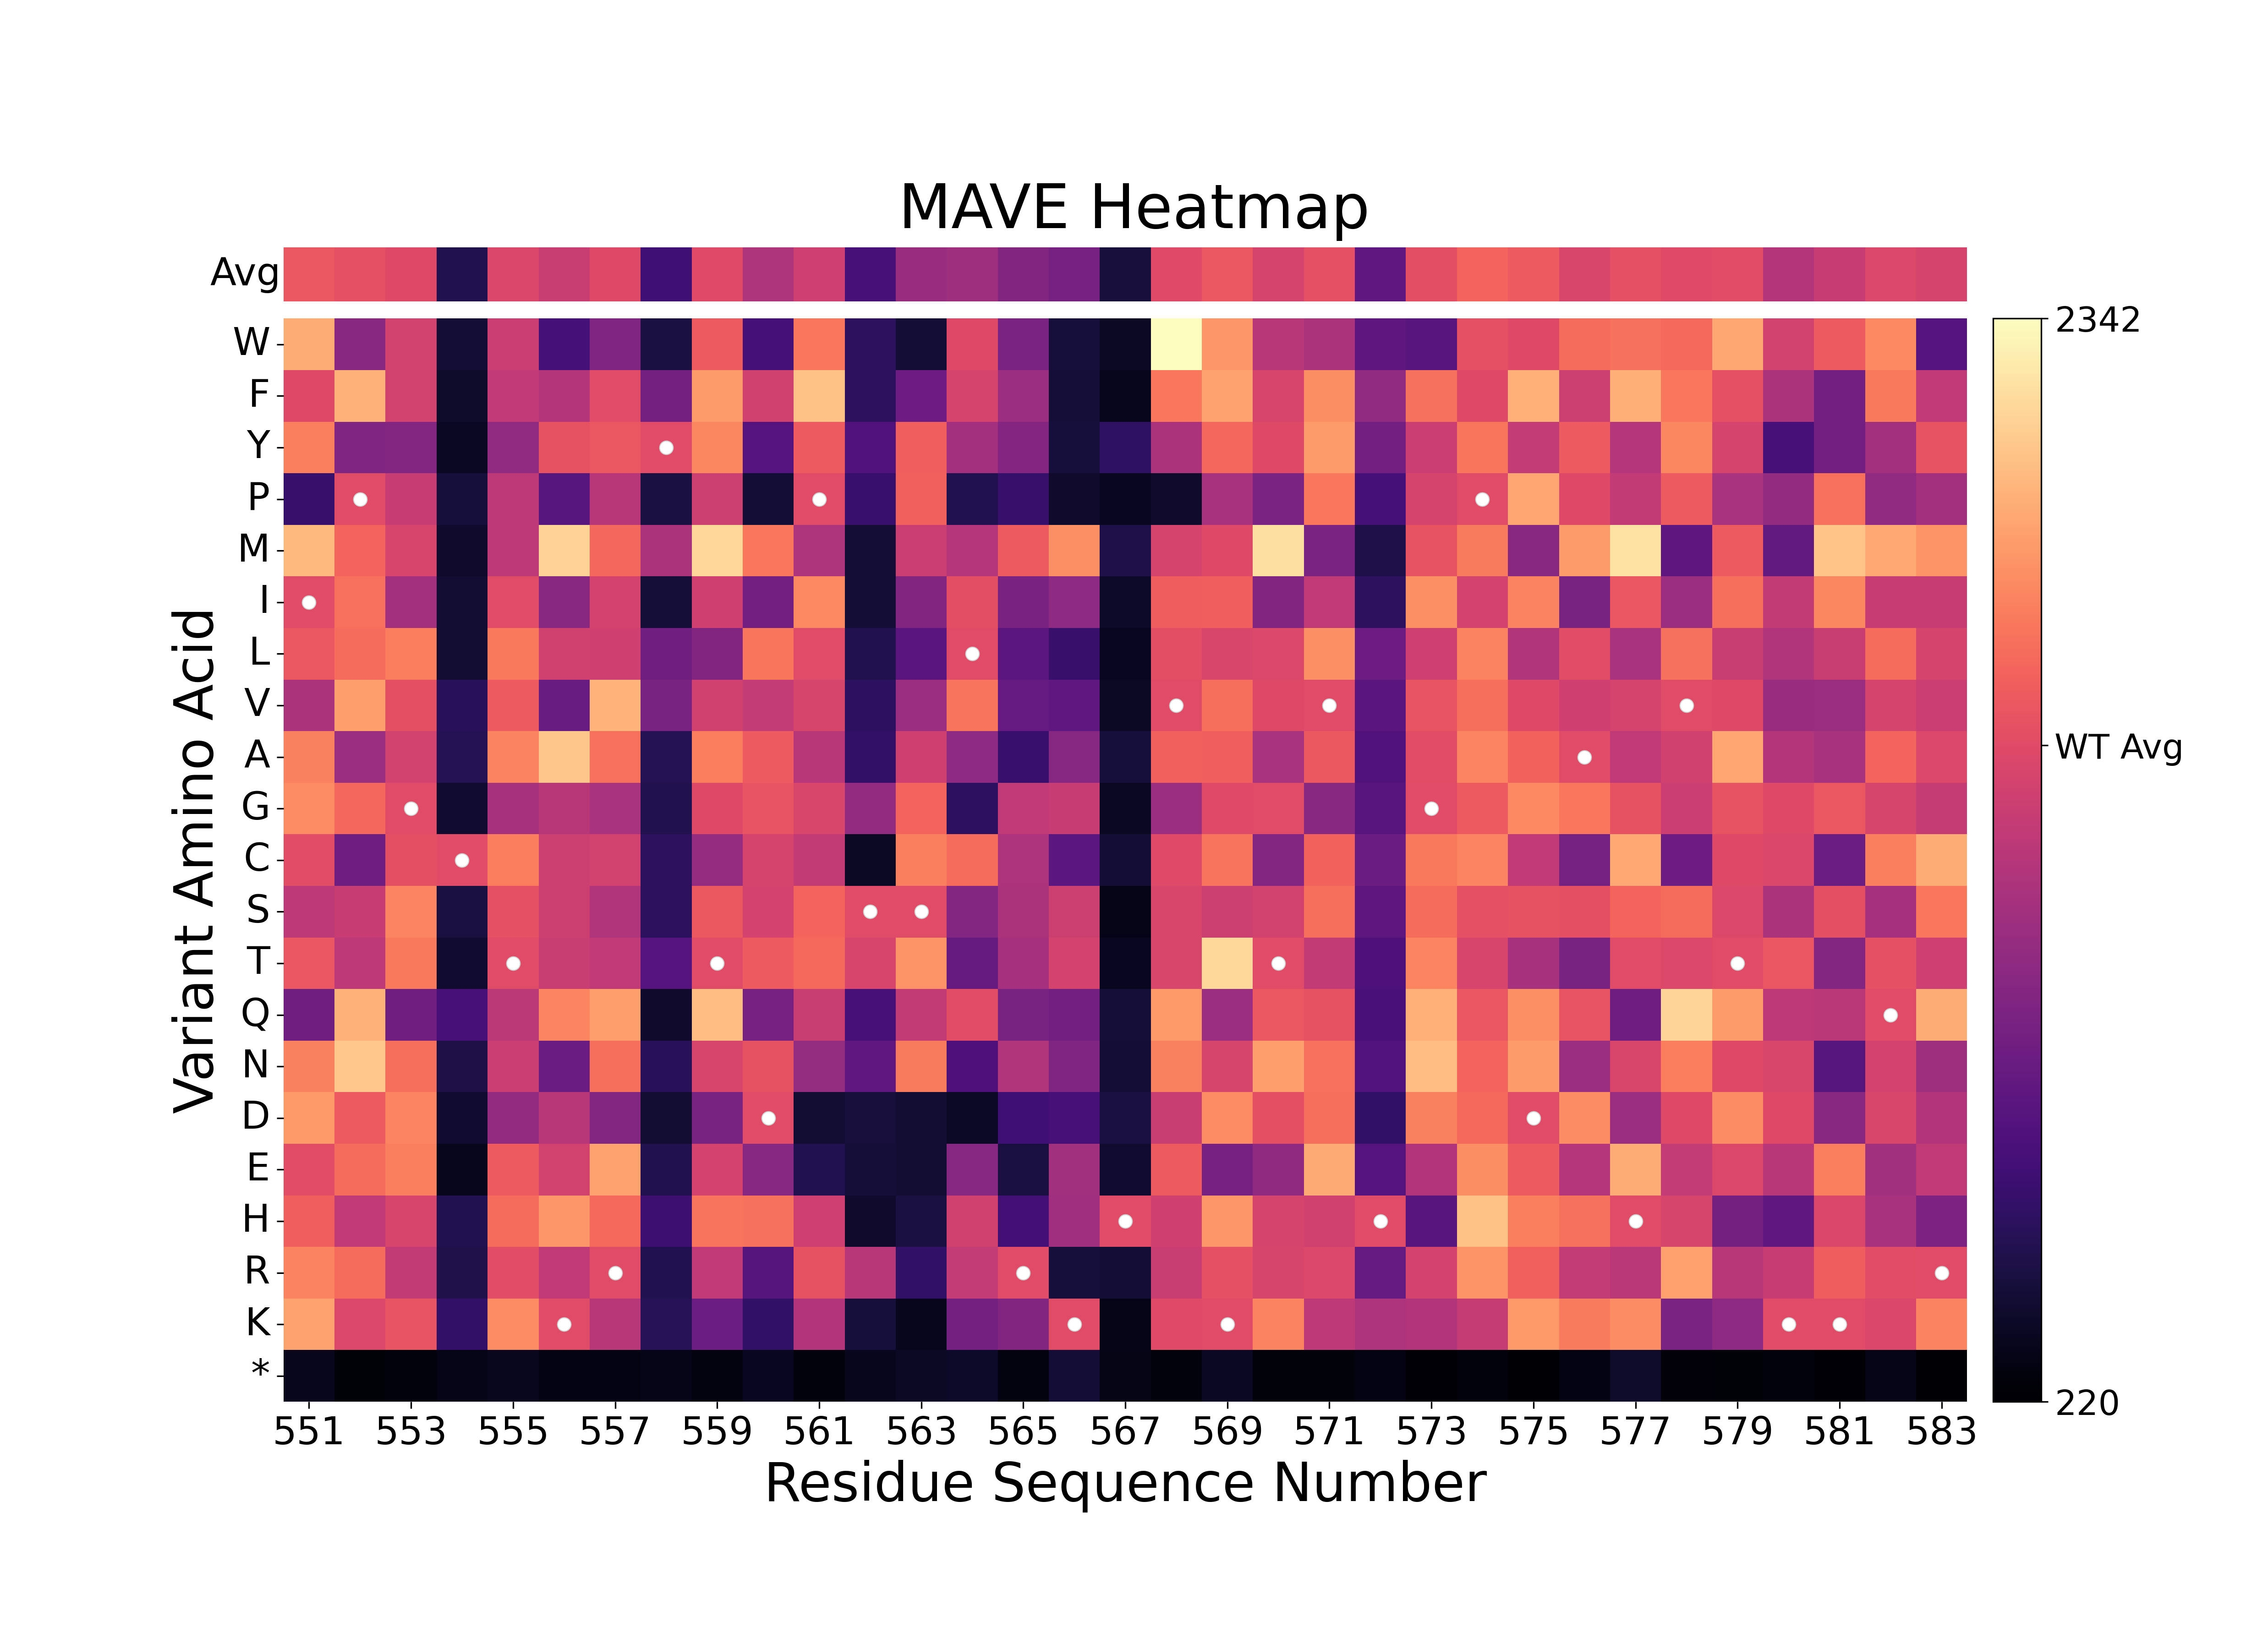

In [30]:
if codon_heatmap_file is None:
    print("No codon heatmap image found for this experiment name.")
else:
    display(Markdown(f"### Codon heatmap (`{codon_heatmap_file.name}`)"))
    display(Image(filename=str(codon_heatmap_file)))

if aa_heatmap_file is None:
    print("No amino-acid heatmap image found for this experiment name.")
else:
    display(Markdown(f"### Amino-acid heatmap (`{aa_heatmap_file.name}`)"))
    display(Image(filename=str(aa_heatmap_file)))